# Makerburn.com Analytics 

In [111]:
import json 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import numpy as np

# Open scraped API calls 

In [48]:
with open('data/mkrburn.json', 'r') as f:
    response = json.load(f)

In [49]:
# find the indexes at which the json contains valid data for stablecoins and non-stablecoin supply 
sc_start = 0
while response[sc_start]['sc_dai'] == 0.0:
    sc_start += 1

non_sc_start = 0
while response[non_sc_start]['non_sc_dai'] == 0.0 or response[non_sc_start]['non_sc_dai'] is None:
    non_sc_start += 1
    
print(response[sc_start]['date'])
print(response[non_sc_start]['date'])

2020-03-17T22:00:00.000Z
2019-11-18T22:00:00.000Z


In [50]:
# edit the json to reflect the valid dates 
sc_json = response[sc_start:]
non_sc_json = response[non_sc_start:]

In [51]:
# make a dataframe that includes the stablecoin ratio and add to dataframe
df_original = pd.DataFrame(non_sc_json)
df = df_original[['date','sc_dai', 'non_sc_dai','annual_fees','surplus',
                 'total_dai_supply',]]
df.rename(columns={'date' : 'Date', 'sc_dai' : 'SC Dai', 'non_sc_dai' : 'Non SC Dai'}, inplace=True)
df['SC Ratio'] = df['SC Dai']/(df['SC Dai']+df['Non SC Dai'])
df['Date'] = df['Date'].apply(lambda x : pd.to_datetime(str(x[:10])))
df.set_index('Date', inplace=True)
df.tail()

SC Dai    Non SC Dai   annual_fees       surplus  \
Date                                                                 
2022-10-02  5.406379e+09  1.052656e+09  1.143684e+07  7.709172e+07   
2022-10-03  5.353533e+09  1.053447e+09  1.145147e+07  7.712477e+07   
2022-10-04  5.377071e+09  1.056034e+09  1.147814e+07  7.700782e+07   
2022-10-05  5.367675e+09  1.055061e+09  1.145953e+07  7.700137e+07   
2022-10-05  5.367675e+09  1.055066e+09  1.145955e+07  7.700194e+07   

            total_dai_supply  SC Ratio  
Date                                    
2022-10-02      6.832618e+09  0.837026  
2022-10-03      6.780563e+09  0.835578  
2022-10-04      6.806821e+09  0.835844  
2022-10-05      6.796539e+09  0.835730  
2022-10-05      6.796544e+09  0.835730

In [52]:
# generate price information dataframe
with open('data/coincap.json', 'r') as f: 
    response = json.load(f)

data = response['data']['points']
list_prices = [row[0] for row in [data[key]['v'] for key in data.keys()]]

df_dict = {'Price' : list_prices}
pricedf = pd.DataFrame(df_dict, index=pd.date_range("11-22-2019", freq="D", periods=len(list_prices)))
pricedf.index.rename('Date',inplace=True)

In [53]:
# add a column that generates the rolling volatility measured by standard deviation the price 
window_size = 20
pricedf['Rolling Std'] = pricedf['Price'].rolling(window_size).std()
pricedf.tail()

Price  Rolling Std
Date                             
2022-10-02  0.999649     0.000278
2022-10-03  1.000060     0.000285
2022-10-04  0.999885     0.000275
2022-10-05  0.999667     0.000276
2022-10-06  0.999754     0.000263

In [54]:
# Merge the dataframes on datetime 
df = df.merge(pricedf, 'outer', 'Date').dropna()
df.head()

SC Dai    Non SC Dai   annual_fees  surplus  total_dai_supply  \
Date                                                                        
2019-12-11     0.0  6.041261e+07  2.416505e+06      0.0      6.125936e+07   
2019-12-12     0.0  6.104779e+07  2.441912e+06      0.0      6.171295e+07   
2019-12-13     0.0  6.158276e+07  2.463310e+06      0.0      6.249020e+07   
2019-12-14     0.0  6.264979e+07  2.505992e+06      0.0      6.308409e+07   
2019-12-15     0.0  6.272666e+07  2.509066e+06      0.0      6.345096e+07   

            SC Ratio     Price  Rolling Std  
Date                                         
2019-12-11       0.0  1.003030     0.004735  
2019-12-12       0.0  1.005456     0.003939  
2019-12-13       0.0  1.003854     0.002786  
2019-12-14       0.0  1.007594     0.002882  
2019-12-15       0.0  1.003221     0.002803

# Plot 1: The price stability of Dai against the stablecoin ratio

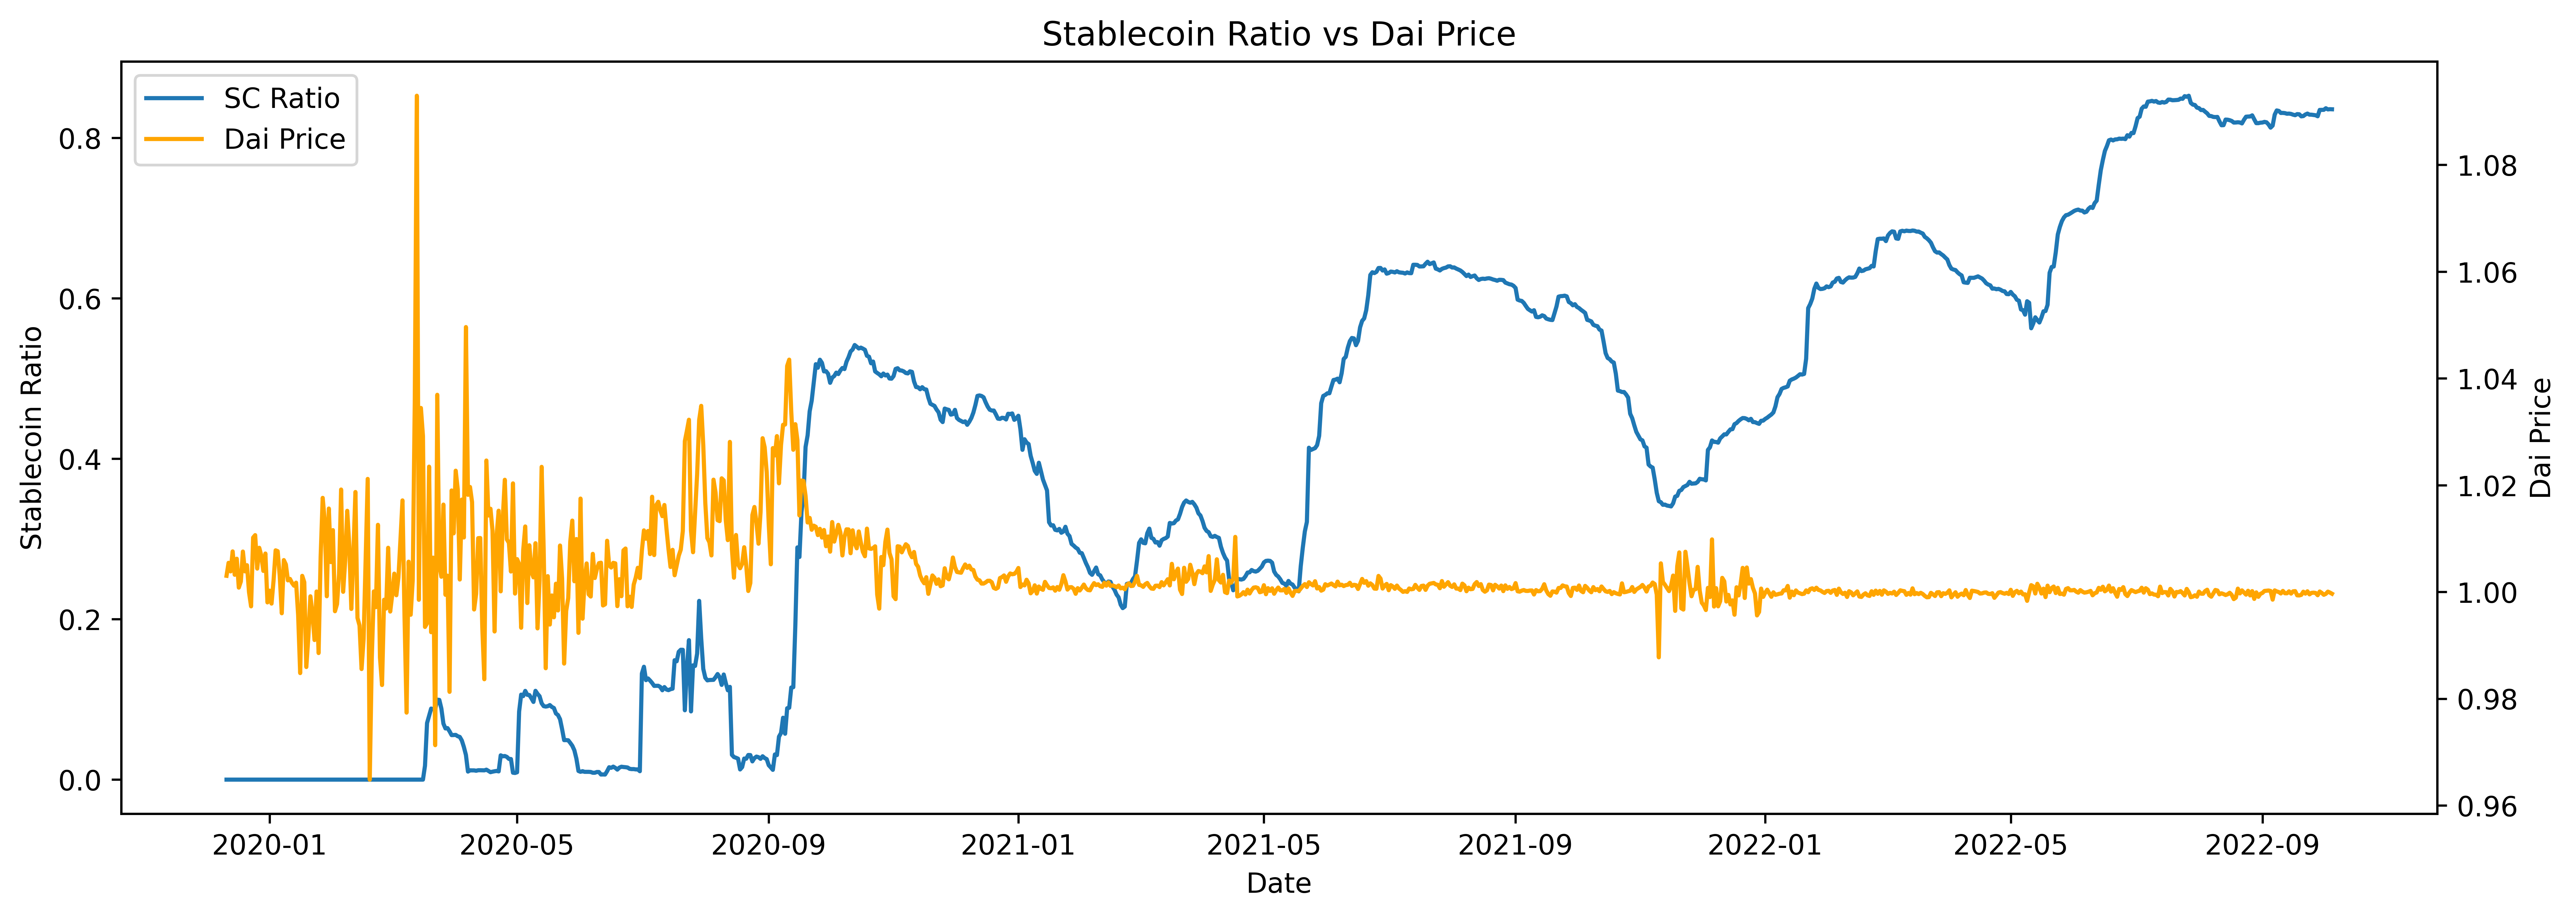

In [55]:
# plot the sc-ratio against the price of Dai 
fig, ax1 = plt.subplots(figsize=(15, 5),dpi=600)
ax1.set_title("Stablecoin Ratio vs Dai Price")
ax1.set_xlabel('Date')
ax1.set_ylabel('Stablecoin Ratio')
l1 = ax1.plot(df.index, df['SC Ratio'])


ax2 = ax1.twinx()
ax2.set_ylabel('Dai Price')
l2 = ax2.plot(df.index, df['Price'],color='orange')

lns = l1+l2
ax1.legend(lns, ['SC Ratio', 'Dai Price'])

#plt.show()
plt.savefig('Dai Price vs Stablecoin ratio')

In [56]:
# export the data to a .dat file to compile in tikz 
plotting_df = df[['SC Ratio','Price']]
plotting_df.to_csv("output.csv")

# Plot 2: Stablecoin ratio vs Surplus buffer 
We want to plot the surplus buffer (normalised by stablecoin supply) against the stability ratio to show that as the stablecoin ratio increases the normalised surplus buffer might be negatively impacted from reduced fees 

In [124]:
# Create the surplus buffer dataframe
surplus_df = df[['surplus','SC Ratio']]
surplus_df['surplus'] = df['surplus']

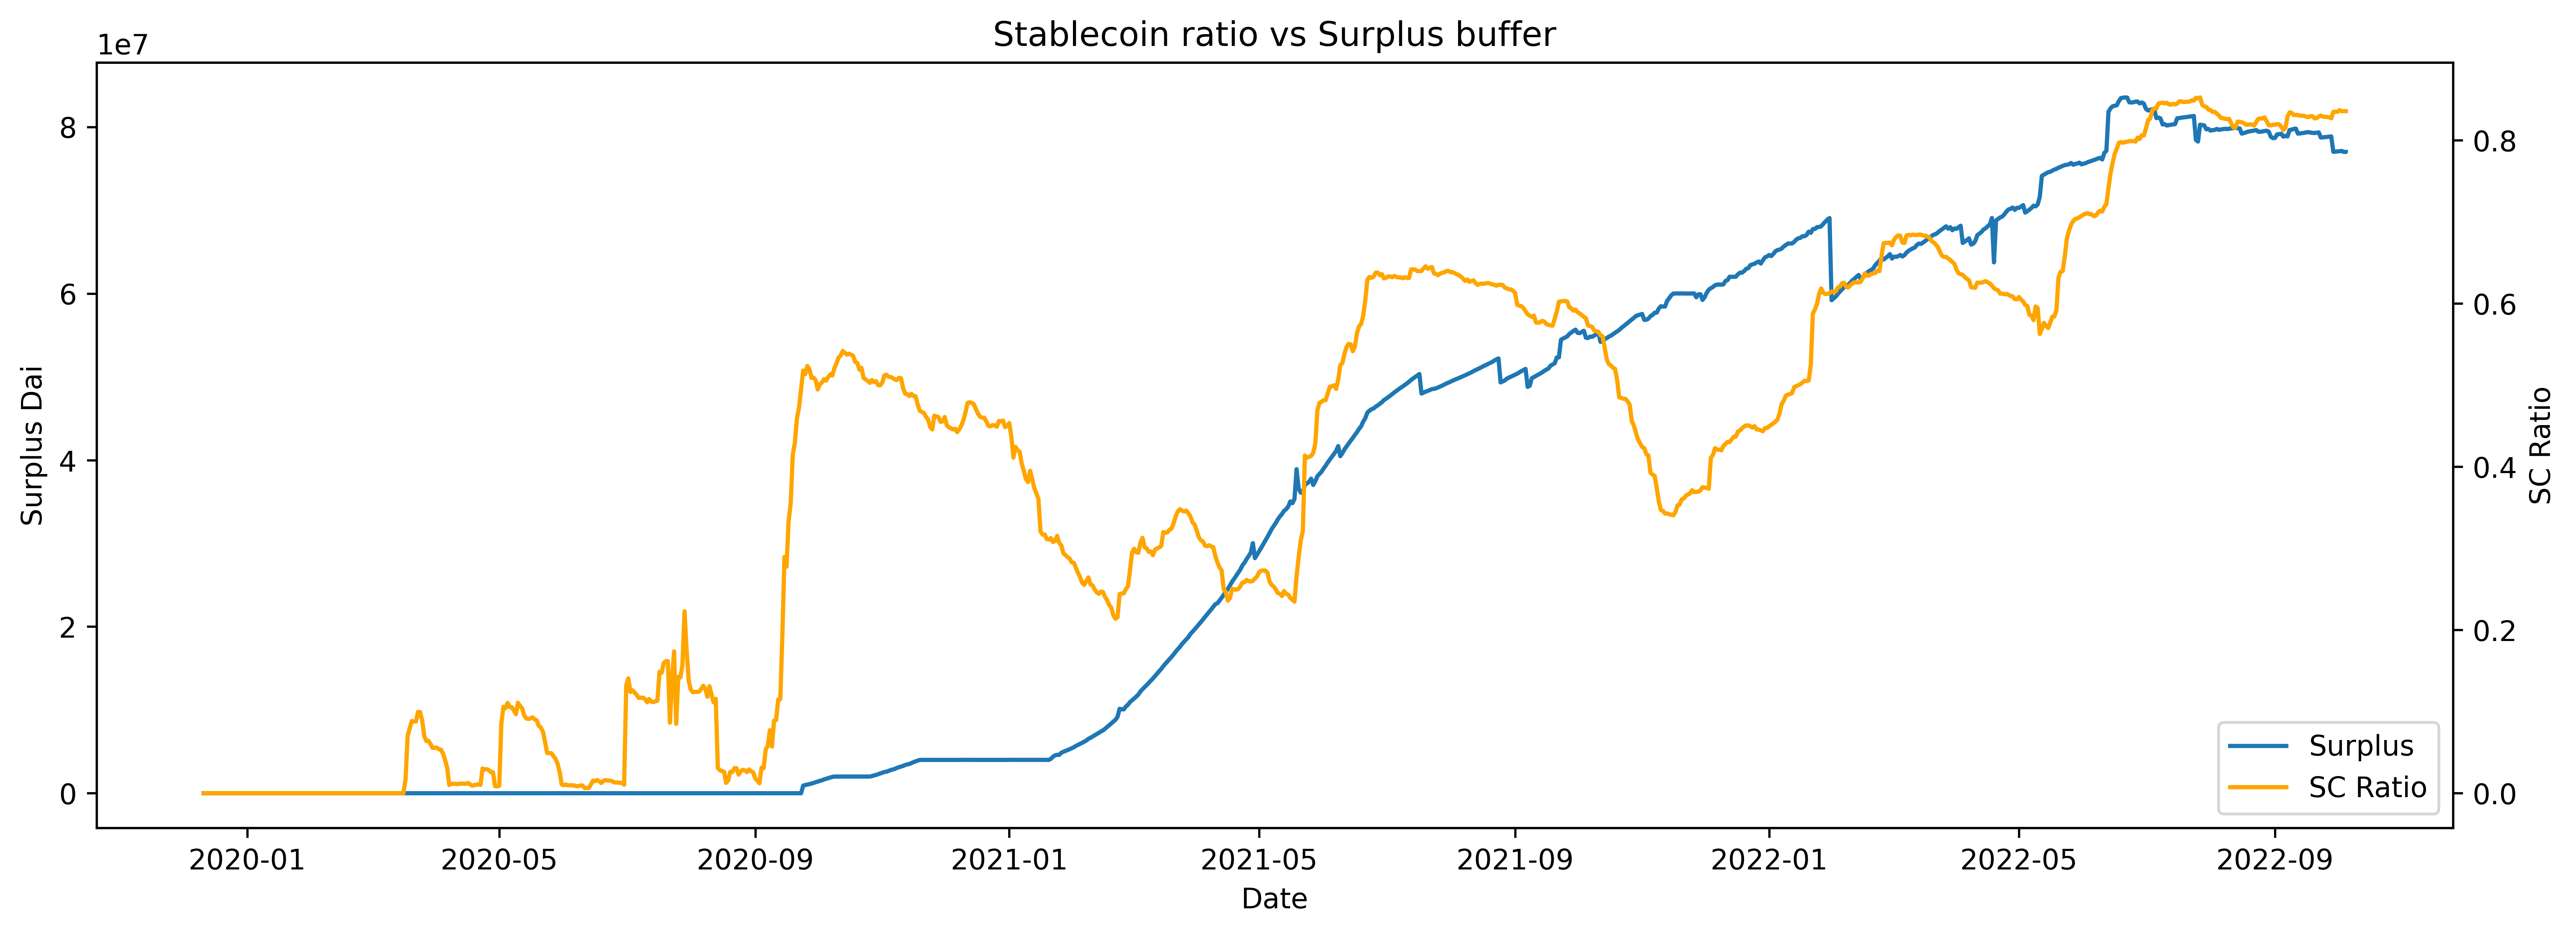

In [125]:
fig, ax1 = plt.subplots(figsize=(15, 5),dpi=600)
ax1.set_title("Stablecoin ratio vs Surplus buffer")
ax1.set_xlabel('Date')
ax1.set_ylabel('Surplus Dai')
l1 = ax1.plot(surplus_df.index, surplus_df['surplus'])


ax2 = ax1.twinx()
ax2.set_ylabel('SC Ratio')
l2 = ax2.plot(surplus_df.index, surplus_df['SC Ratio'],color='orange')

lns = l1+l2
ax1.legend(lns, ['Surplus', 'SC Ratio'], loc='lower right')

plt.show()

In [126]:
s1 = surplus_df['SC Ratio']
s2 = surplus_df['surplus']
corr = s1.corr(s2)
corr

0.8432864085583984

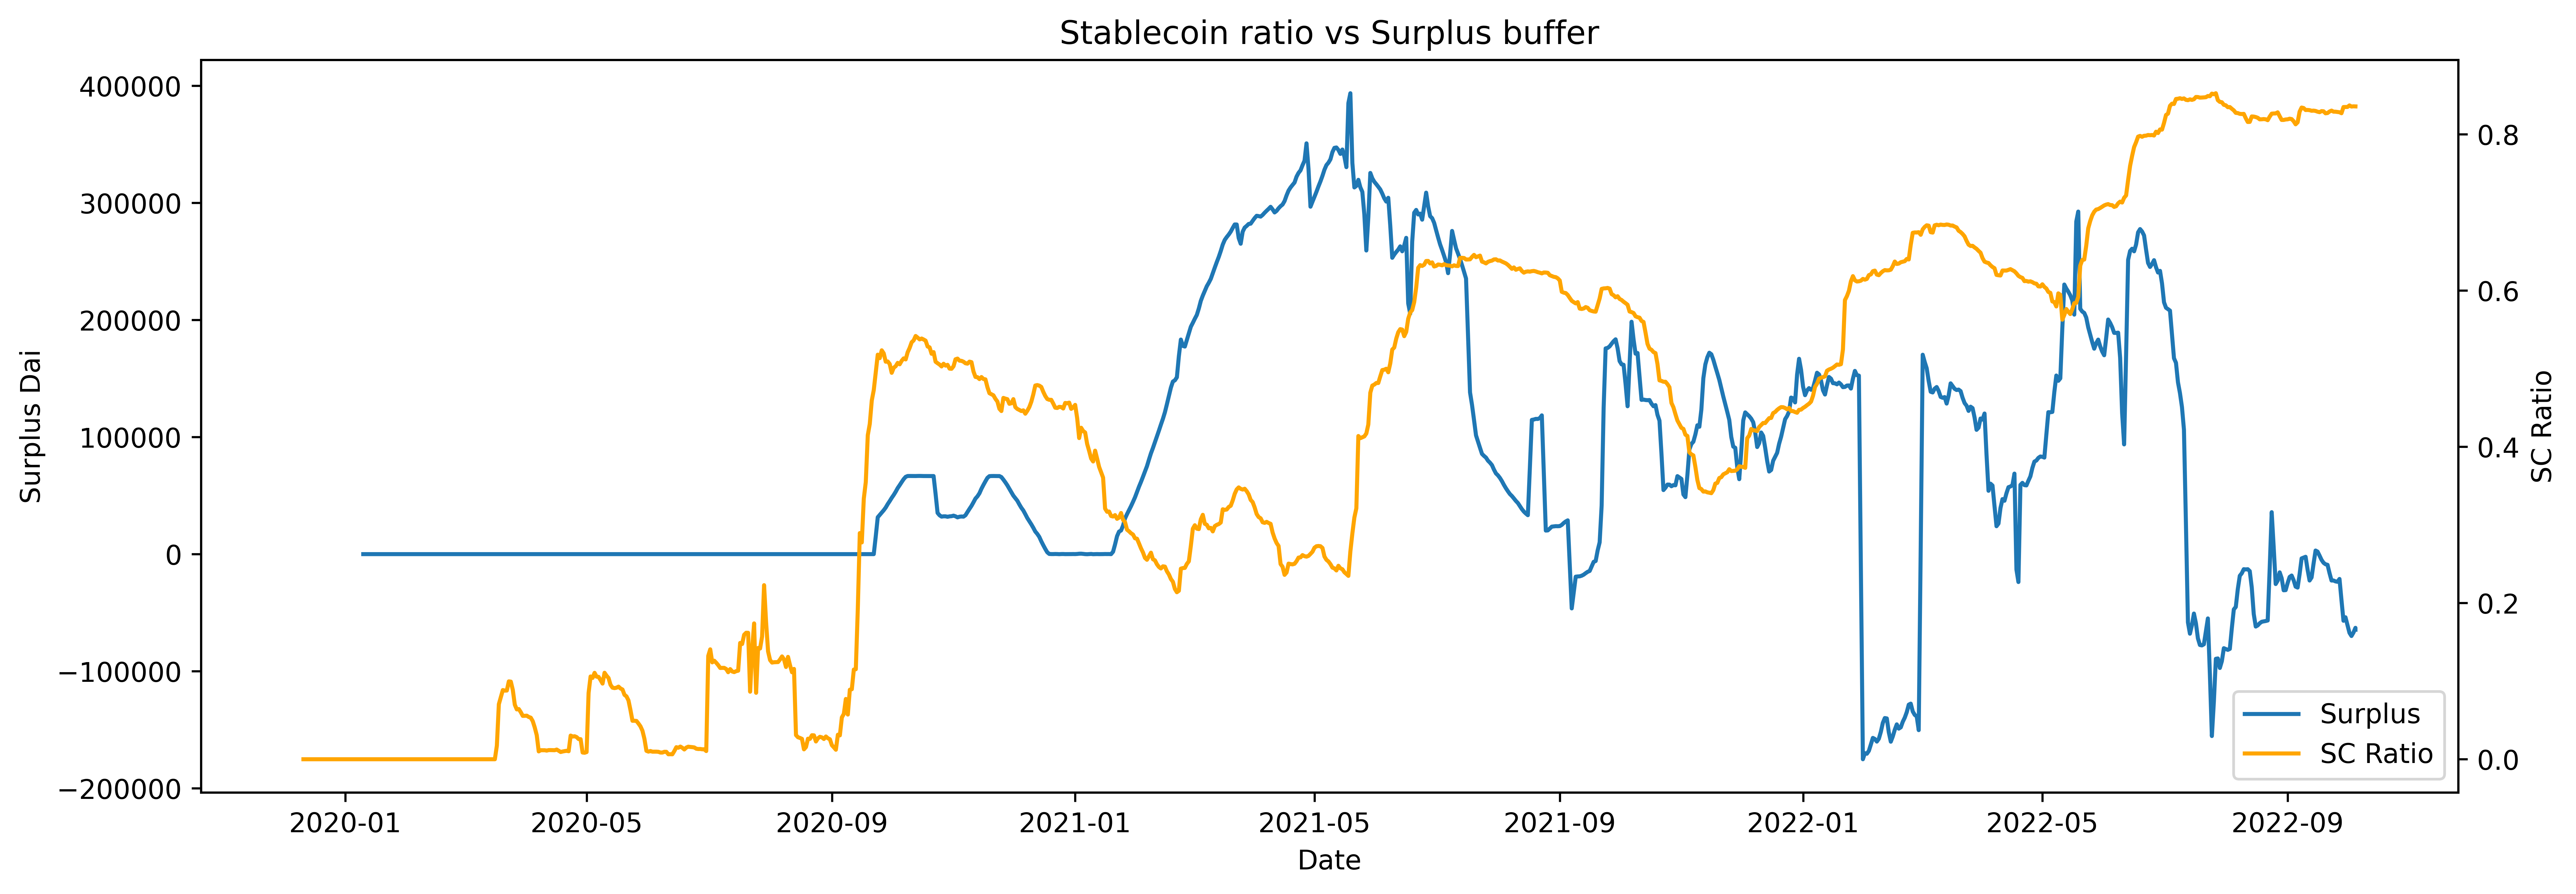

In [127]:
# take the discrete derivative of the time pricing information 
#surplus_derivative = np.gradient(s2)
fig, ax1 = plt.subplots(figsize=(15, 5),dpi=600)
ax1.set_title("Stablecoin ratio vs Surplus buffer")
ax1.set_xlabel('Date')
ax1.set_ylabel('Surplus Dai')
l1 = ax1.plot(surplus_df.index, np.gradient(surplus_df['surplus'].rolling(window_size).mean()))


ax2 = ax1.twinx()
ax2.set_ylabel('SC Ratio')
l2 = ax2.plot(surplus_df.index, surplus_df['SC Ratio'],color='orange')

lns = l1+l2
ax1.legend(lns, ['Surplus', 'SC Ratio'], loc='lower right')

plt.show()

In [133]:
s1 = surplus_df['SC Ratio']
s2 = pd.Series(np.gradient(surplus_df['surplus'].rolling(window_size).mean()))
corr = s1.corr(s2)
corr

AttributeError: 'Series' object has no attribute 'Index'

Since the protocol only has to discharge the buffer when it gets too high, going through periods of low
fee generation dont matter as it can just retain the buffer. Maybe its best to look at fees generated per Dai over the same period of time. 

# Plot 3: Fees/Dai vs the stablecoin ratio

In [60]:
# Create the Fees/Dai dataframe
fees_df = df[['annual_fees','SC Ratio']]
fees_df['fees_per_dai'] = df['annual_fees']/df['total_dai_supply']

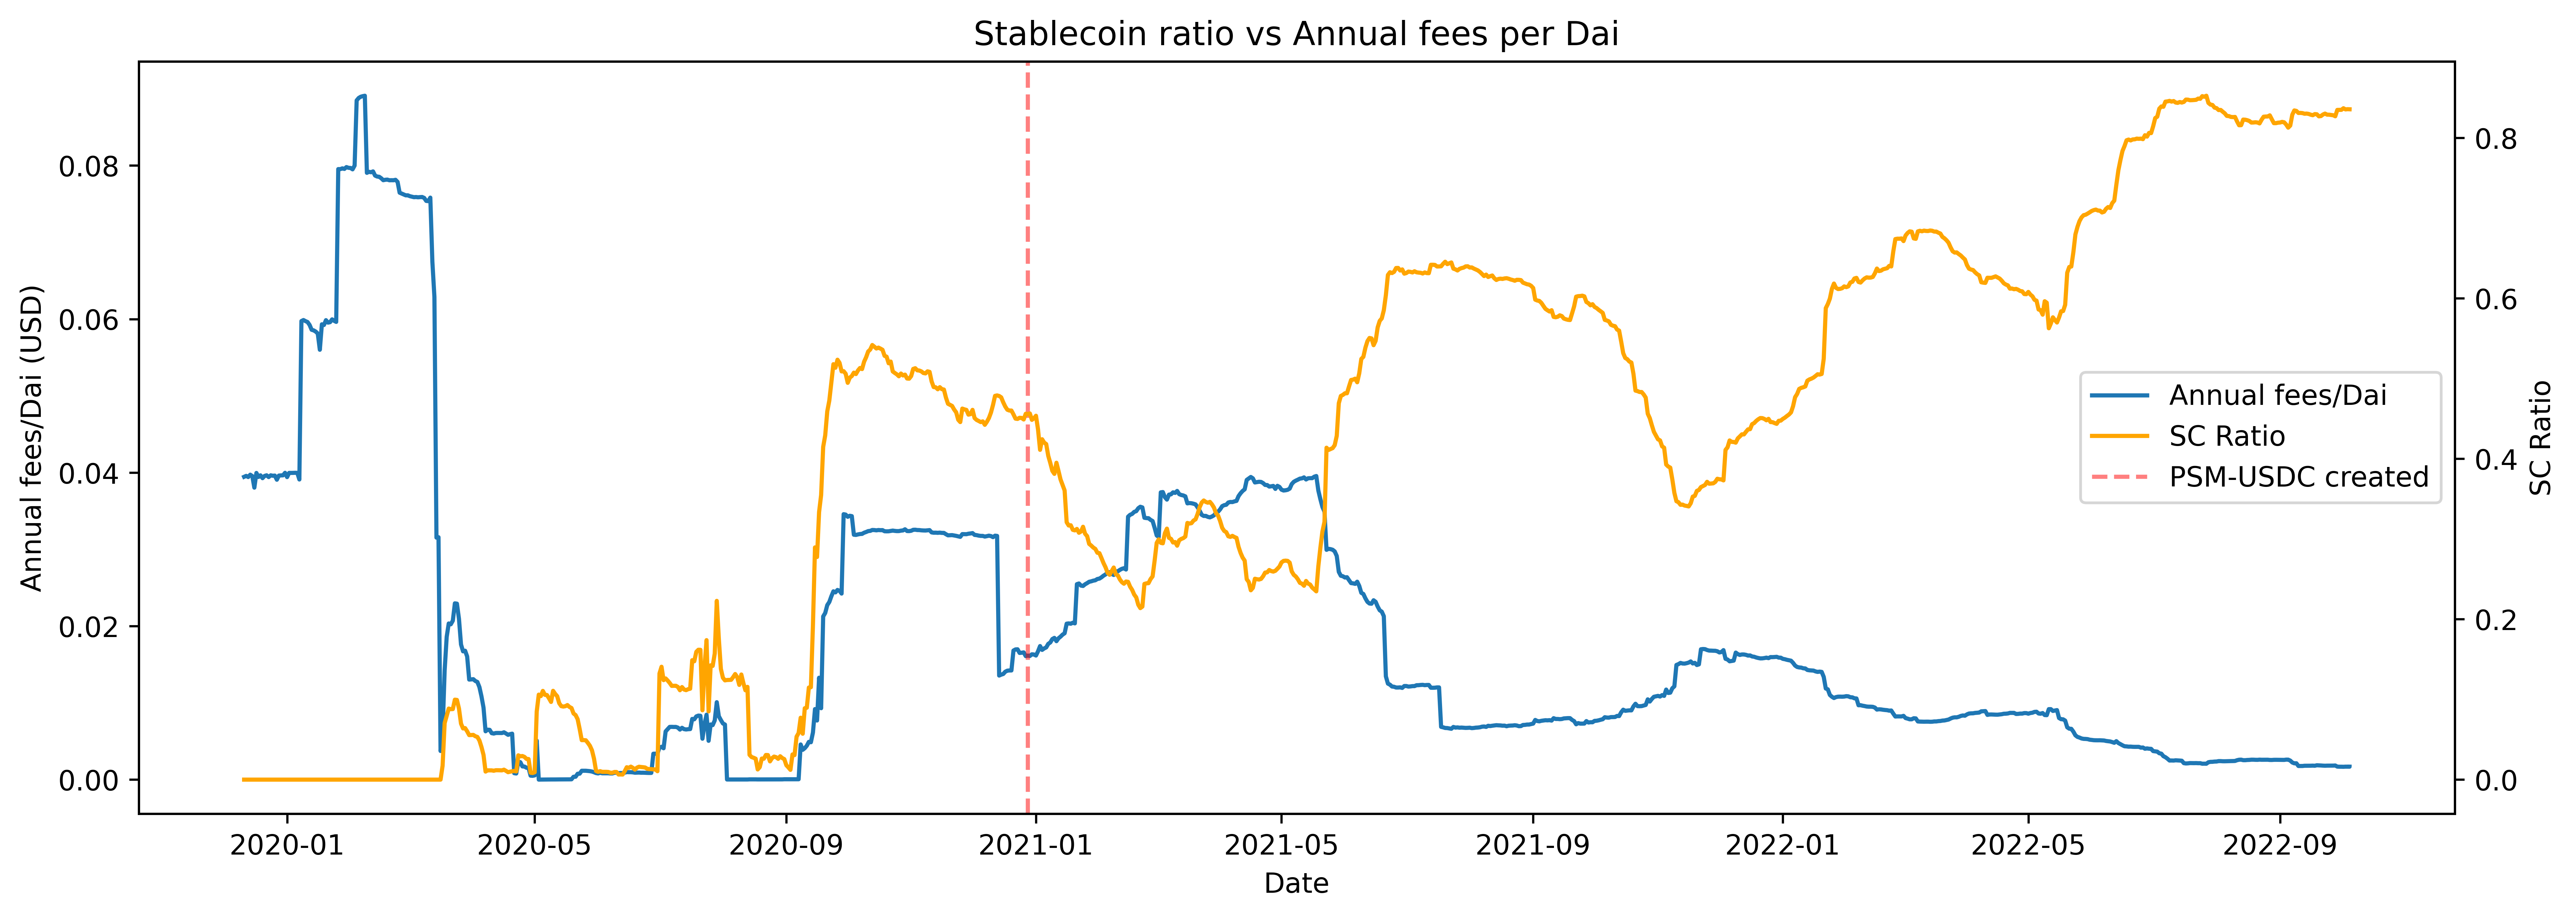

In [61]:
fig, ax1 = plt.subplots(figsize=(15, 5),dpi=600)
ax1.set_title("Stablecoin ratio vs Annual fees per Dai")
ax1.set_xlabel('Date')
ax1.set_ylabel('Annual fees/Dai (USD)')
l1 = ax1.plot(fees_df.index, fees_df['fees_per_dai'])
l3 = ax1.axvline(dt.datetime(2020, 12, 28), color = 'r', alpha=0.5, ls='--',label='PSM-USDC created')

ax2 = ax1.twinx()
ax2.set_ylabel('SC Ratio')
l2 = ax2.plot(fees_df.index, fees_df['SC Ratio'],color='orange')

lns = l1+l2+[l3]
ax1.legend(lns, ['Annual fees/Dai', 'SC Ratio', 'PSM-USDC created'], loc='center right')

plt.show()

In [62]:
# calculate the correlation coefficient between the fees per dai and SC ratio 
# We consider this correlation from after Black thursday and the introduction of PSM-USDC vault (2020-12-28)
# since we want to look at the effects of SC collateral and PSM effects on system profitability. 
# the correlation coefficient becomes:
s1 = fees_df['fees_per_dai'].loc['2020-12-28':]
s2 = fees_df['SC Ratio'].loc['2020-12-28':]
corr = s1.corr(s2)
corr

-0.8911227818627308

In [135]:
# up until the point of PSM-USDC
s1 = fees_df['fees_per_dai'].loc['2020-03-17':'2020-12-28']
s2 = fees_df['SC Ratio'].loc['2020-03-17':'2020-12-28']
corr = s1.corr(s2)
corr

0.9070766815588941

In [63]:
# export the data to a .dat file to compile in tikz 
plotting_df2 = fees_df[['fees_per_dai','SC Ratio']]
plotting_df2.to_csv("annual_fees.csv") 


# Plot 4: Volatility of Dai against the stablecoin ratio

In [95]:
# edit the window size to see how it effects the regression
window_size = 30
df['Rolling Std'] = df['Price'].rolling(window_size).std()
df.tail()

SC Dai    Non SC Dai   annual_fees       surplus  \
Date                                                                 
2022-10-02  5.406379e+09  1.052656e+09  1.143684e+07  7.709172e+07   
2022-10-03  5.353533e+09  1.053447e+09  1.145147e+07  7.712477e+07   
2022-10-04  5.377071e+09  1.056034e+09  1.147814e+07  7.700782e+07   
2022-10-05  5.367675e+09  1.055061e+09  1.145953e+07  7.700137e+07   
2022-10-05  5.367675e+09  1.055066e+09  1.145955e+07  7.700194e+07   

            total_dai_supply  SC Ratio     Price  Rolling Std  
Date                                                           
2022-10-02      6.832618e+09  0.837026  0.999649     0.000376  
2022-10-03      6.780563e+09  0.835578  1.000060     0.000371  
2022-10-04      6.806821e+09  0.835844  0.999885     0.000361  
2022-10-05      6.796539e+09  0.835730  0.999667     0.000355  
2022-10-05      6.796544e+09  0.835730  0.999667     0.000270

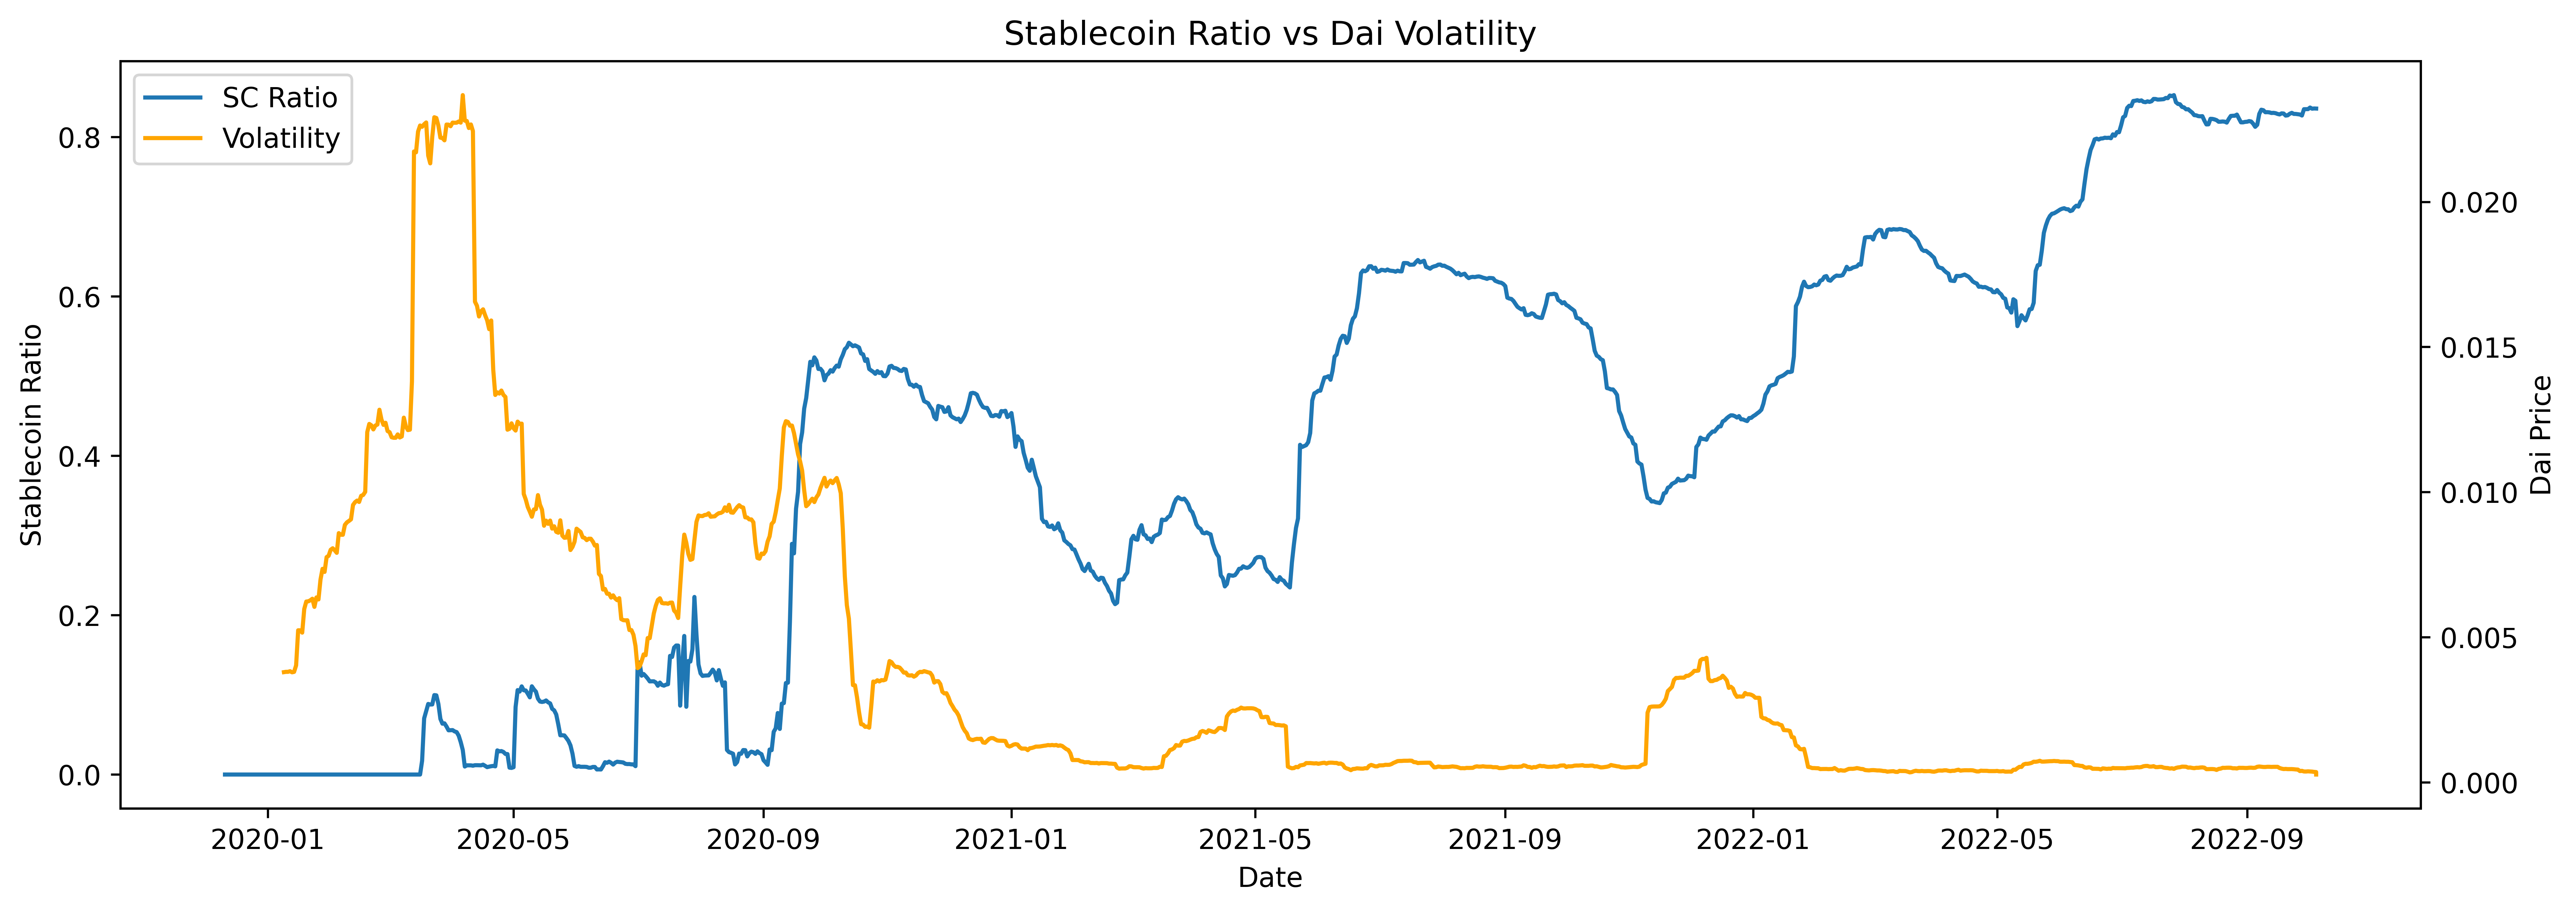

In [96]:
# plot the sc-ratio against the price of Dai 
fig, ax1 = plt.subplots(figsize=(15, 5),dpi=600)
ax1.set_title("Stablecoin Ratio vs Dai Volatility")
ax1.set_xlabel('Date')
ax1.set_ylabel('Stablecoin Ratio')
l1 = ax1.plot(df.index, df['SC Ratio'])


ax2 = ax1.twinx()
ax2.set_ylabel('Dai Price')
l2 = ax2.plot(df.index, df['Rolling Std'],color='orange')

lns = l1+l2
ax1.legend(lns, ['SC Ratio', 'Volatility'])

#plt.show()
plt.savefig('Dai Price vs Stablecoin ratio')

In [97]:
# calculate the correlation coefficient between the volatility and SC ratio 
s1 = df['SC Ratio']
s2 = df['Rolling Std']
corr = s1.corr(s2)
corr

-0.7039202651189422

In [98]:
# export the data to a .dat file to compile in tikz 
#plotting_df = df[['SC Ratio','Rolling Std']]
#plotting_df.to_csv("volatility.csv")

# Volatility regression: Predict volatility using the stablecoin ratio

In [99]:
from sklearn.linear_model import LinearRegression
import numpy as np

## Plot variables  

In [146]:
# we want to run the regression excluding the data from Black thursday of Dai
feature = np.array(df['SC Ratio'].loc['2020-05-01':]).reshape(-1,1)
target = np.array(df['Rolling Std'].loc['2020-05-01':])

#feature = np.array(df['SC Ratio'].loc['2021-12-01':]).reshape(-1,1)
#target = np.array(df['Rolling Std'].loc['2021-12-01':])

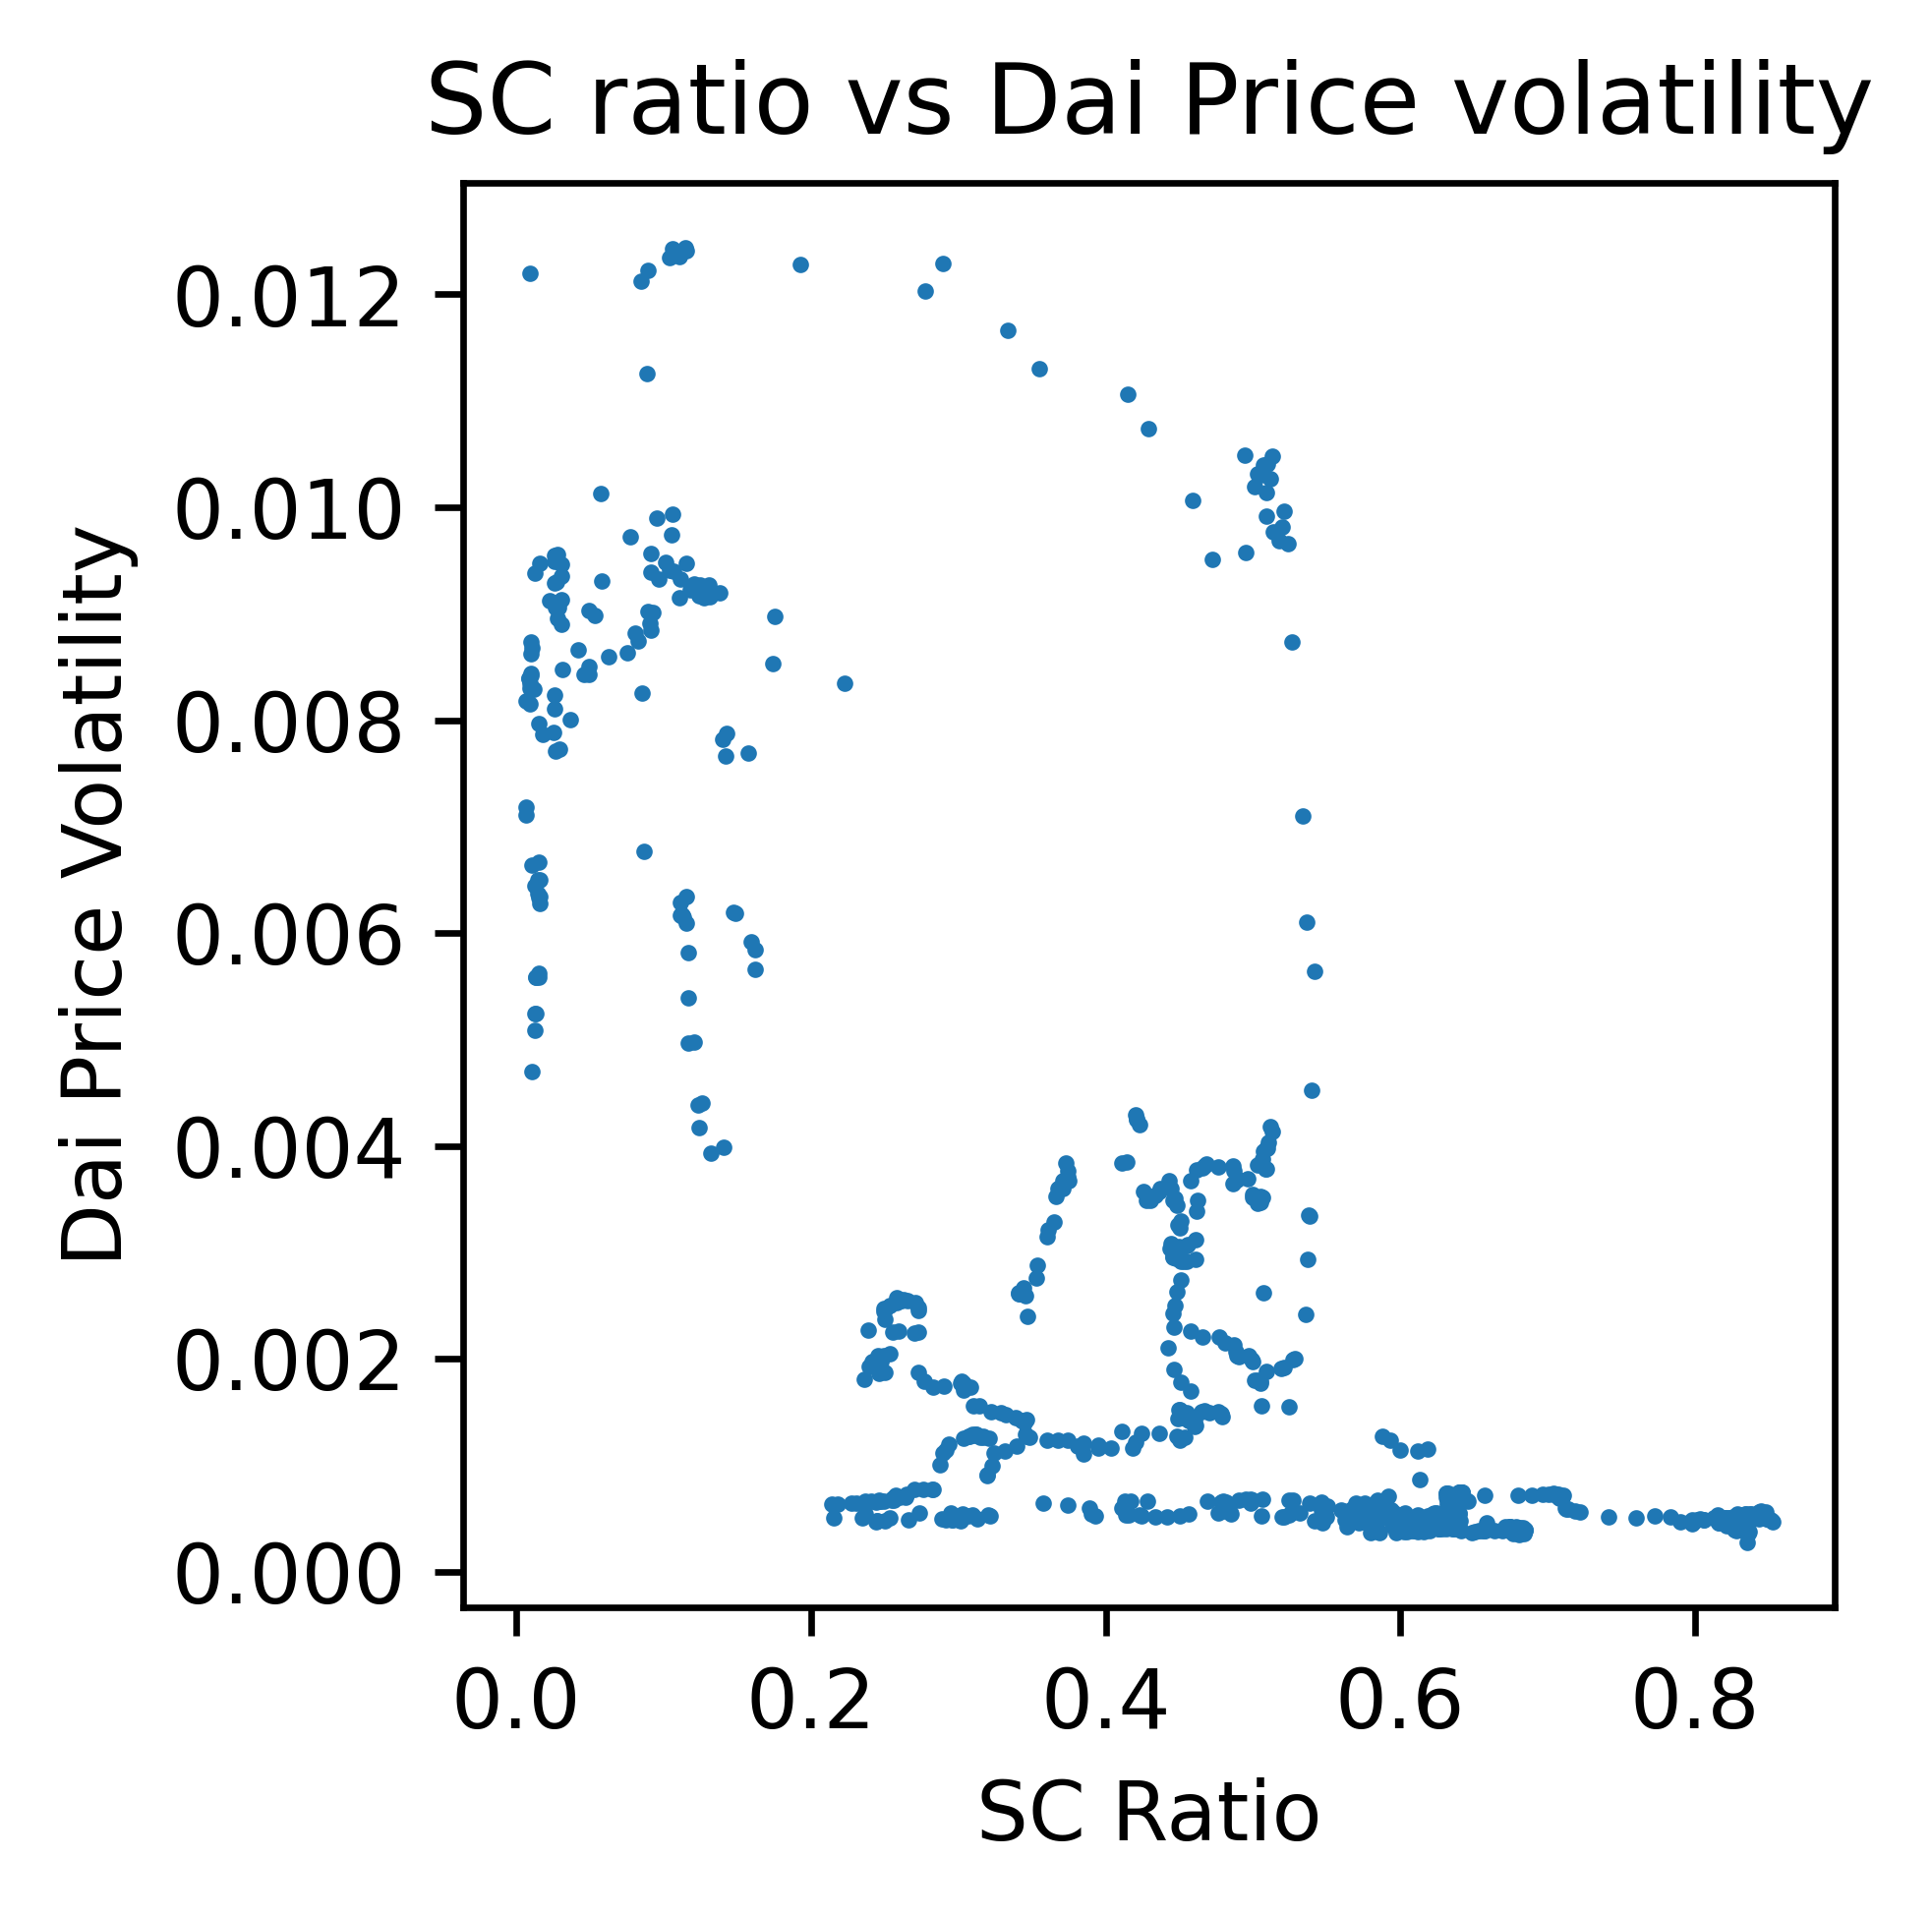

In [150]:
# plot the regression variables against each other for the data 
plt.figure(figsize=(3, 3.2),dpi=600)
plt.title("SC ratio vs Dai Price volatility")
plt.xlabel("SC Ratio")
plt.ylabel("Dai Price Volatility")
plt.scatter(feature, target, s=1.0)
plt.savefig("regression_plot", bbox_inches = "tight")

In [85]:
model = LinearRegression()

In [86]:
regression = model.fit(feature, target)

In [87]:
print("Intercept:", regression.intercept_)
print("coefficient:", regression.coef_[0])

Intercept: 0.006810304655345243
coefficient: -0.00906618444304292


## Plotting the regression

In [88]:
# Process the regression for plotting 
predicted_volatility = abs(regression.coef_[0] * feature + regression.intercept_)
index2 = pd.date_range(start='2020-05-01', periods=len(predicted_volatility))
pred_vol_df = pd.DataFrame(data = {'Date' : index2, "regression" : predicted_volatility[:,0]})
pred_vol_df.set_index('Date', inplace=True)

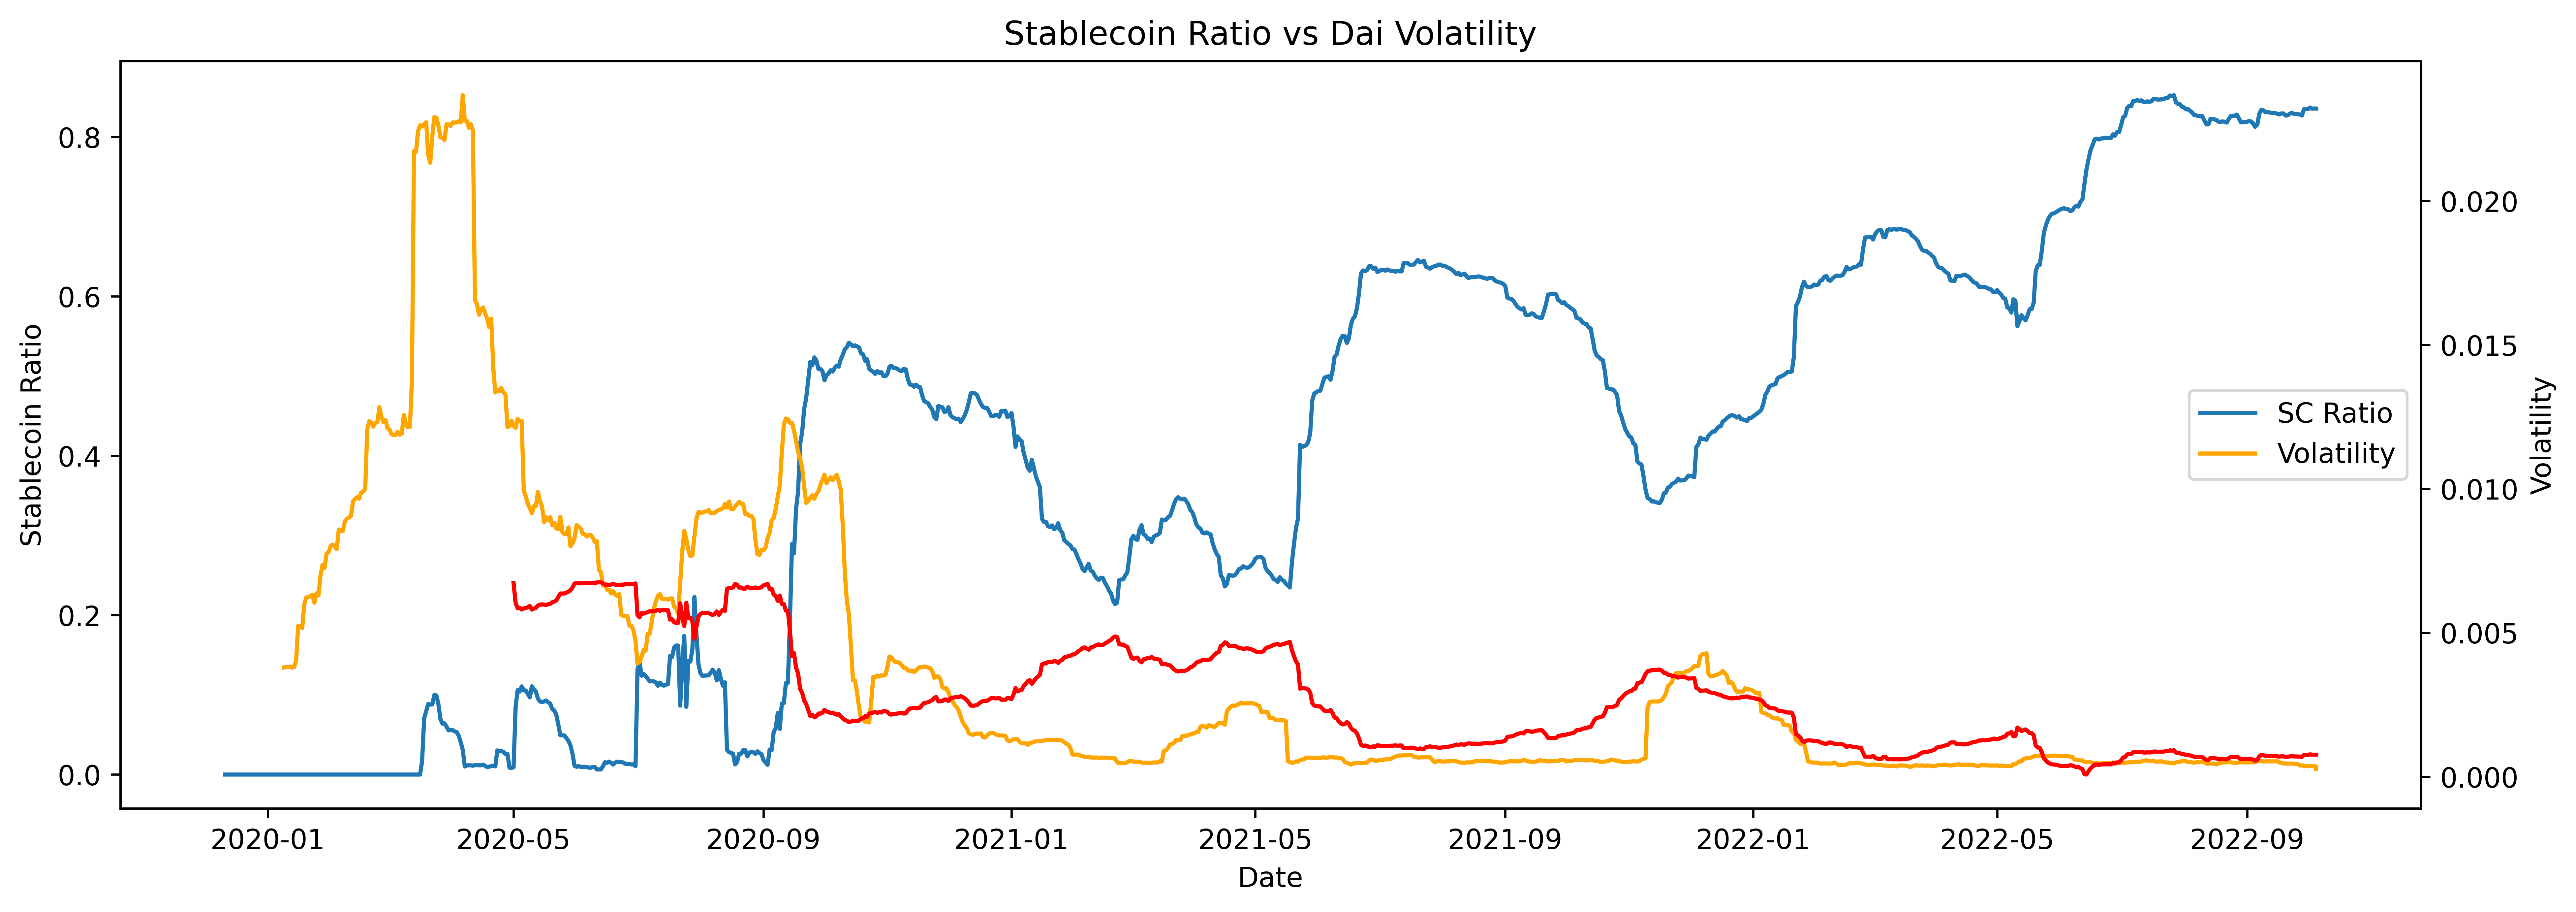

In [89]:
# plot the original graph 
fig, ax1 = plt.subplots(figsize=(15, 5),dpi=600)
ax1.set_title("Stablecoin Ratio vs Dai Volatility")
ax1.set_xlabel('Date')
ax1.set_ylabel('Stablecoin Ratio')
l1 = ax1.plot(df.index, df['SC Ratio'])


ax2 = ax1.twinx()
ax2.set_ylabel('Volatility')
l2 = ax2.plot(df.index, df['Rolling Std'],color='orange')
l3 = ax2.plot(df.index[142:], predicted_volatility, color='red')
#l4 = ax2.axvline(dt.datetime(2020, 12, 28), color = 'r', alpha=0.5, ls='--',label='PSM-USDC created')

lns = l1+l2+[l3]
ax2.legend(lns, ['SC Ratio', 'Volatility', 'Predicted volatility'], loc='center right')

plt.show()

In [75]:
# Save the data 
plotting_df3 = df[['Rolling Std','SC Ratio']]
plotting_df3.to_csv("volatility.csv") 

#datapoints_plot = list(zip())

#save the regression data 
pred_vol_df.to_csv("regression.csv")

## Analysis of regression 

The regression shows that the volatility (n-day rolling standard deviation) of MakerDao is inversely proportional to the stablecoin ratio of collateral. 

We can further explore this relationship by adjusting the window by which we take the volatility calculation. 

Concretely we extract the relationship that:

$$\operatorname{std}_{n}  = -0.0085 * \operatorname{SC}_{\operatorname{ratio}} +  0.0063  $$

where the $n$-day window is an adjustable hyperparameter of the model. 

We can further explore this relationship by finding the average fees paid per for all stablecoin collateral. This tells us how strongly correlated the bounds of the arbitrage opportunity (defined by fees payable upon minting) are with the volatility. We leave this to be completed as future work. 